Importar as bibliotecas necessárias, principalmente a sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.impute import SimpleImputer

Define um estilo para os gráficos e determina o caminho do arquivo. Os arquivos utilizados precisam estar em um padrão de colunas para que o script consiga rodá-los.

Inclusive, é importante saber também qual a página da planilha na qual se quer calcular o TOMI Index

In [2]:
plt.style.use(["bmh"])

file_name = "./tests/@CN_OGX-101.xlsx"

# Carrega os dados do arquivo Excel
dataframe = pd.read_excel(file_name, skiprows=0, decimal=",", sheet_name="LONGÁ")

Agora, vamos determinar variáveis para os dados do artigo, no qual foram determinados empiricamente valores de probabilidade (TOMI Index) para valores de TOC/TN, C13CORG e D15N.

In [3]:
TOC_TN_ARTIGO = np.array([4, 4, 4, 4, 10, 10, 10, 10, 100, 100, 100, 100])
C13CORG_ARTIGO = np.array([-10, -22, -25, -34, -10, -22, -25, -34, -10, -22, -25, -34])
D15N_ARTIGO = np.array([12, 3, 0, -12, 12, 3, 0, -12, 12, 3, 0, -12])
PROBABILIDADE = np.array([0, 10, 20, 30, 20, 30, 40, 50, 90, 95, 98, 100])

Determinando variáveis para os valores das amostras da Bacia

In [4]:
amostra_TOC_TN = dataframe["TOC/TN"].values
amostra_C13CORG = dataframe["d13C"].values
amostra_D15N = dataframe["d15N"].values

Agora começa o processo, primeiro, colocamos os valores das amostras em uma única matriz

In [6]:
# Combina os dados do artigo em uma matriz
DADOS_ARTIGO = np.column_stack((TOC_TN_ARTIGO, C13CORG_ARTIGO, D15N_ARTIGO))
TOMI_PROBABILIDADE = PROBABILIDADE

Após isso, determina-se o Kernel para a Regressão do Processo Gaussiano. Kernel seria a função que determina a similaridade entre os pontos, e a função Radial Basis Function (RBF) é a mais comum para isso, juntamente com uma constante (essa constante pode ser usada como parte de um kernel de produto, onde dimensiona a magnitude do outro fator (kernel), ou como parte de um kernel de soma, onde modifica a média do processo gaussiano.).

In [7]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

Inicializa-se o modelo de Regressão do Processo Gaussiano, e ajusta-se o modelo com os valores dos dados do artigo.

In [8]:
# Inicializa o GaussianProcessRegressor com o kernel definido
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# Treina o modelo com os dados do artigo
gp.fit(DADOS_ARTIGO, TOMI_PROBABILIDADE)

c:\Users\aalbano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

Após treinar o modelo com os dados do artigo, é possível fazer a predição do TOMI Index para os valores da Bacia. Para isso, primeiro colocar os dados das amostras em uma matriz, remover os valores NaN, e depois fazer a predição.

In [9]:
# Combina os dados das amostras em uma matriz
DADOS_AMOSTRA = np.column_stack((amostra_TOC_TN, amostra_C13CORG, amostra_D15N))
# Imputa valores faltantes usando a média
imputer = SimpleImputer(strategy="mean")
DADOS_AMOSTRA = imputer.fit_transform(DADOS_AMOSTRA)

# Prediz o índice TOMI com os dados imputados
TOMI_INDEX, sigma = gp.predict(DADOS_AMOSTRA, return_std=True)

Só que o valor que sai de TOMI_INDEX dessa predição é invertido, então precisa-se inverter o valor para que fique correto.

In [10]:
TOMI_INDEX = 100 - TOMI_INDEX

Agora, para visualizar os dados:

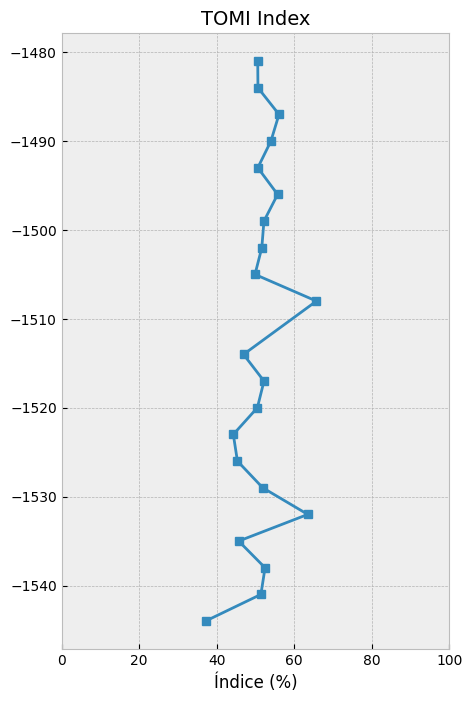

In [11]:
plt.figure(figsize=(5, 8))
plt.plot(TOMI_INDEX, dataframe["TVDSS"], "s-")
plt.xlim(0, 100)
plt.title("TOMI Index", fontsize=14)
plt.xlabel("Índice (%)", fontsize=12)
plt.grid(True)
plt.show()